## Train dataset on MNIST :(

In [8]:
%reload_ext autoreload
%autoreload 2

In [9]:
import torch.nn as nn

import torchvision.transforms as transforms

import numpy as np

import torchvision
import torch

In [10]:
from tqdm import tqdm

In [11]:
device = 'cuda'

In [12]:
# net = torchvision.models.resnet18(pretrained=True)
net = torchvision.models.resnet50(pretrained=True)

# Replace 1st layer to use it on grayscale images
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
net = net.to(device)

In [13]:
# net.load_state_dict(torch.load("./resnet18_mnist.pth"))
net.load_state_dict(torch.load("./resnet50_mnist.pth"))

<All keys matched successfully>

## Extract features from picture

In [29]:
import cv2
import matplotlib.pyplot as plt


from data_preprocessing import crop_and_warp, find_corners_of_largest_polygon, pre_process_image, remove_stuff


In [15]:
img = cv2.imread("./sudoku_real_1.jpeg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pre_preocessed = pre_process_image(gray)

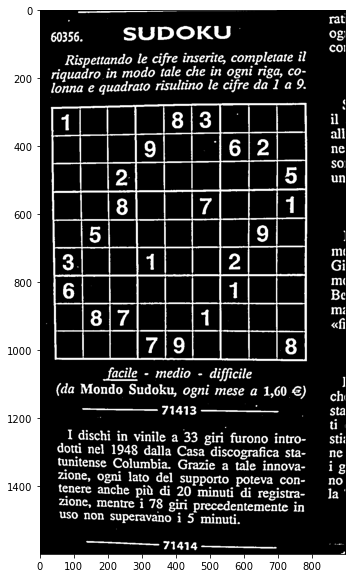

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(pre_preocessed, cmap='gray')



In [17]:
corners = find_corners_of_largest_polygon(pre_preocessed)

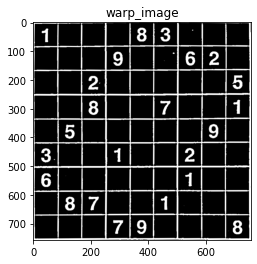

In [18]:
cropped = crop_and_warp(pre_preocessed, corners)

## Solve sudoku!

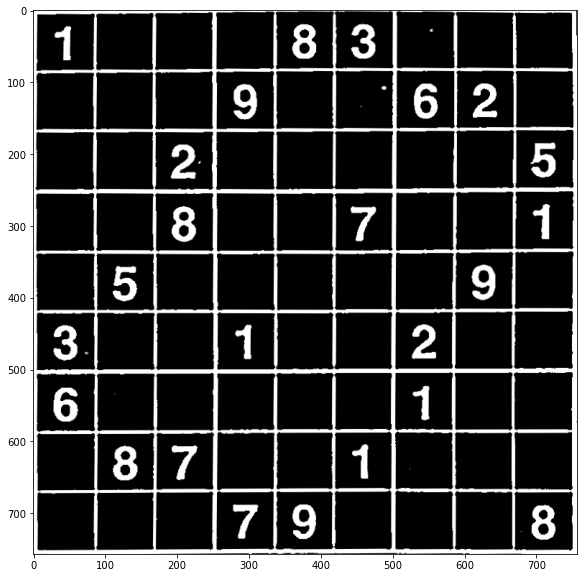

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(cropped, cmap='gray')

In [20]:
_, cropped_t = cv2.threshold(cropped,127,255,cv2.THRESH_TOZERO)

In [21]:
cropped = cropped_t

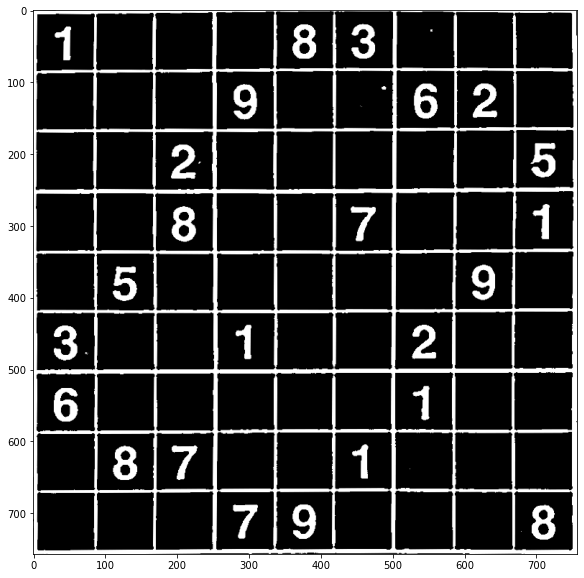

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_t, cmap='gray')

In [23]:
def slice_grid(grid, i, j, W):
    """AAA"""
    
    i_start = i * W
    i_end = i_start + W
    
    j_start = j * W
    j_end = j_start + W
        
    aa = grid[i_start:i_end, j_start:j_end]
    return aa
    

In [24]:
w, h = cropped.shape

W = w//9


In [25]:
# # aa = slice_grid(thresholded, 1, 4, W) # a 6
# aa = slice_grid(thresholded, 4, 6, W) # a 6
# # aa = slice_grid(thresholded, 3, 4, W) # a 3
# # aa = slice_grid(thresholded, 0, 1, W) # an empty square
# # aa = slice_grid(thresholded, 0, 0, W) # a 1
# plt.figure(figsize=(10,10))
# plt.imshow(aa, cmap='gray')

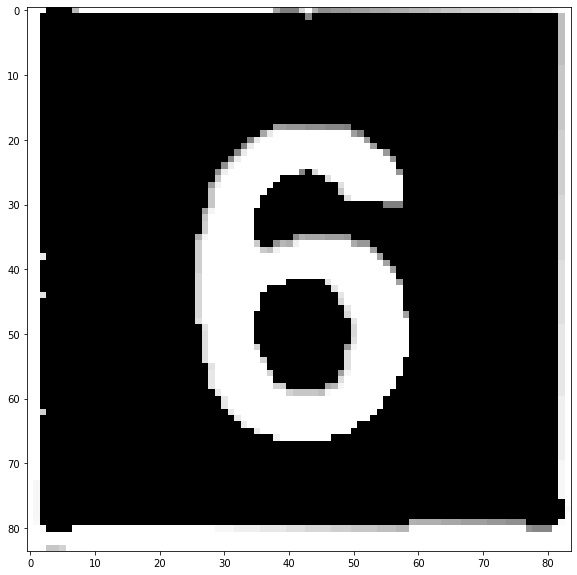

In [27]:
aa = slice_grid(cropped, 1, 6, W)
plt.figure(figsize=(10,10))
plt.imshow(aa, cmap='gray')

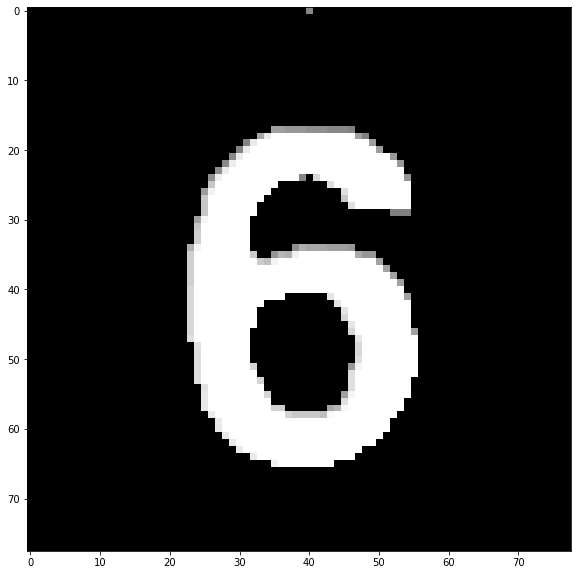

In [28]:
out = remove_stuff(aa)

plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')

In [36]:
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)

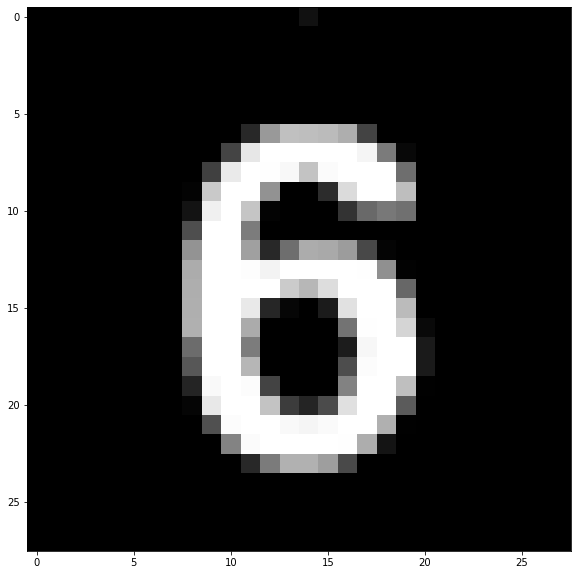

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(resized, cmap='gray')

In [38]:
(resized != resized.min()).sum()

173

In [ ]:
from sudoku_solver import find_empty_grid, print_board, solve_array

In [39]:
def smart_classify(resized, net, threshold=75, device='cuda', conf_threshold=0.9, debug=False):
    
    # Identify blank cells
    if (resized != resized.min()).sum() < threshold:
        return " "
    
    net.eval()
    iii = torch.Tensor(resized).to(device).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        out = net(iii)
        
    if debug:
        print(out)
        
    sm = torch.nn.functional.softmax(out, dim=1)
        
    print(sm)
    _, P = torch.max(out, 1)
    
    
    
    digit = P.item()
    
    conf = sm.squeeze()[digit].item()
    
    if digit != 0 and conf>conf_threshold:
        return str(digit)
    else:
        return " "    

In [41]:
smart_classify(resized/255, net, debug=True)

tensor([[-0.1436, -2.0637, -2.9577, -2.3611, -2.4970,  5.1707,  3.9080, -2.6289,
          0.4413, -0.8993]], device='cuda:0')
tensor([[3.7811e-03, 5.5427e-04, 2.2671e-04, 4.1167e-04, 3.5937e-04, 7.6842e-01,
         2.1737e-01, 3.1496e-04, 6.7864e-03, 1.7758e-03]], device='cuda:0')


' '

In [295]:
1/0

ZeroDivisionError: division by zero

In [296]:
w, h = cropped.shape

W = w//9

In [297]:
cropped_t

array([[255, 255, 247, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [247, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [329]:
digits = list()


for i in range(9):
    i_start = i * W
    i_end = i_start + W
    
    for j in range(9):
        
        j_start = j * W
        j_end = j_start + W
        
        # Slice a cell from the original image
        aa = slice_grid(cropped_t, i, j, W)
        
        bb = aa.astype(float)/255
#         bb = 1 - bb
        
        # Isolate digit from rest of the cell
        out = remove_stuff(bb)
        
        # Resize to 28x28
        resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
        digits.append(smart_classify(resized, net, conf_threshold=0.9))


tensor([[1.2135e-05, 5.7366e-01, 4.7737e-05, 4.3569e-05, 1.8163e-04, 1.7629e-05,
         1.0804e-05, 4.2595e-01, 5.6431e-05, 2.8726e-05]], device='cuda:0')
tensor([[2.7552e-04, 2.8776e-03, 4.4199e-04, 9.5385e-04, 8.0480e-04, 4.0327e-04,
         6.3717e-04, 2.1398e-04, 9.9288e-01, 5.0711e-04]], device='cuda:0')
tensor([[3.8613e-04, 3.7598e-04, 1.9653e-03, 9.6079e-01, 9.7982e-05, 3.2937e-02,
         2.3658e-04, 1.2244e-03, 1.2846e-03, 7.0583e-04]], device='cuda:0')
tensor([[3.3004e-05, 6.4804e-05, 7.1281e-05, 1.7830e-04, 1.3041e-04, 6.8178e-04,
         1.2896e-05, 7.9328e-05, 1.9204e-04, 9.9856e-01]], device='cuda:0')
tensor([[1.5591e-03, 2.3728e-04, 9.5544e-05, 2.6662e-04, 1.3839e-04, 9.4760e-01,
         4.6670e-02, 1.5354e-04, 2.4114e-03, 8.6940e-04]], device='cuda:0')
tensor([[7.1302e-08, 7.2760e-07, 1.0000e+00, 6.3989e-07, 3.2458e-07, 6.9380e-08,
         5.1519e-07, 2.6430e-07, 4.6954e-07, 5.9869e-08]], device='cuda:0')
tensor([[2.1721e-07, 2.1945e-06, 9.9999e-01, 2.9932e-06, 8

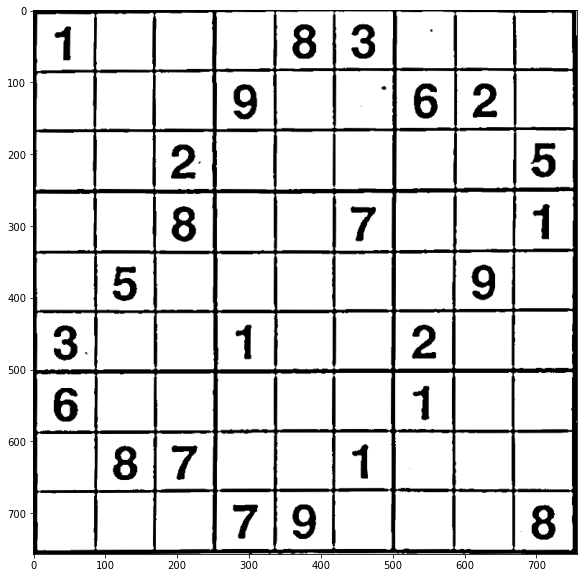

In [330]:
plt.figure(figsize=(10,10))
plt.imshow(255-cropped, cmap='gray')

In [331]:
def convert(d):
    if d == ' ':
        return 0
    else:
        return int(d)

In [332]:
digits_int = np.array([convert(d) for d in digits])

digits_int = digits_int.reshape((9, 9))
digits_int


array([[0, 0, 0, 0, 8, 3, 0, 0, 0],
       [0, 0, 0, 9, 0, 0, 5, 2, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 5],
       [0, 0, 8, 0, 0, 7, 0, 0, 1],
       [0, 5, 0, 0, 0, 0, 0, 9, 0],
       [5, 0, 0, 0, 1, 0, 2, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 8, 7, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 7, 0, 0, 0, 0, 8]])

In [333]:
digits_list = [list(ll) for ll in list(digits_int)]

In [334]:
print_board(digits_list)

. . .  | . 8 3  | . . .
. . .  | 9 . .  | 5 2 .
. . 2  | . . .  | . . 5
- - - - - - - - - - - - - 
. . 8  | . . 7  | . . 1
. 5 .  | . . .  | . 9 .
5 . .  | . 1 .  | 2 . .
- - - - - - - - - - - - - 
. . .  | . 1 .  | 1 . .
. 8 7  | . . 1  | . . .
. . .  | 7 . .  | . . 8


In [196]:

digits_list = list(digits_list)

solve_array(digits_list)

True

In [197]:
print_board(digits_list)

1 7 6  | 3 8 9  | 2 5 4
4 2 5  | 1 6 7  | 8 9 3
3 9 8  | 2 4 5  | 1 6 7
- - - - - - - - - - - - - 
7 4 2  | 6 3 8  | 5 1 9
8 5 3  | 9 2 1  | 4 7 6
9 6 1  | 7 5 4  | 3 8 2
- - - - - - - - - - - - - 
2 3 7  | 8 1 6  | 9 4 5
6 8 4  | 5 9 3  | 7 2 1
5 1 9  | 4 7 2  | 6 3 8
